# (논문) Chest X-ray
> kaggle_chest x-ray data를 활용한 CNN and CAM

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영
- categories: [Study]

---

### import 

In [1]:
import torch 
from fastai.vision.all import * 
import cv2 

In [2]:
import fastbook
from fastbook import *

In [3]:
from fastai.vision.widgets import *

### data

refer : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [4]:
path=Path('/home/khy/chest_xray/chest_xray') 

In [5]:
path.ls()

(#5) [Path('/home/khy/chest_xray/chest_xray/train'),Path('/home/khy/chest_xray/chest_xray/test'),Path('/home/khy/chest_xray/chest_xray/chest_xray'),Path('/home/khy/chest_xray/chest_xray/__MACOSX'),Path('/home/khy/chest_xray/chest_xray/val')]

In [6]:
files=get_image_files(path)

In [7]:
files

(#11712) [Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0766-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1318-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0160-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1327-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0489-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0509-0001-0002.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0761-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0416-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0566-0001.jpeg'),Path('/home/khy/chest_xray/chest_xray/train/NORMAL/IM-0411-0001.jpeg')...]

In [8]:
dls = ImageDataLoaders.from_folder(path, train='train', valid_pct=0.2, item_tfms=Resize(224))      

In [9]:
dls.vocab

['NORMAL', 'PNEUMONIA']

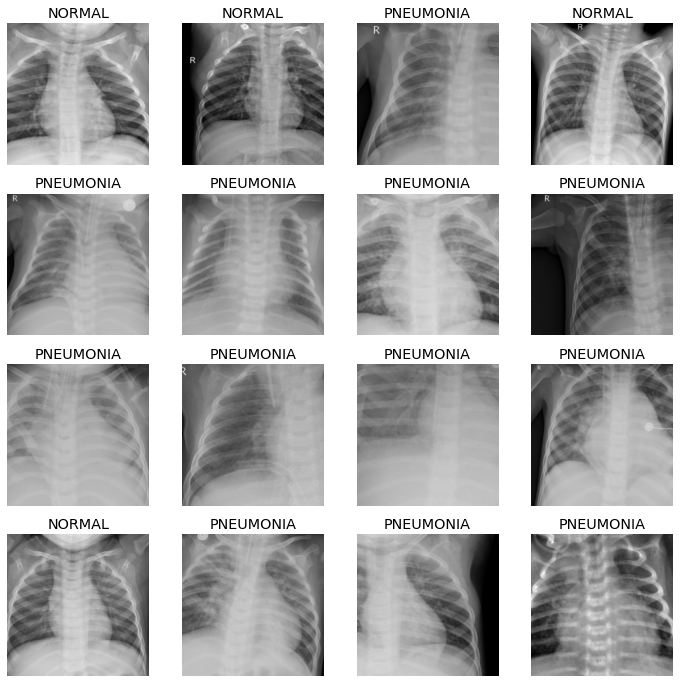

In [10]:
dls.show_batch(max_n=16)

In [11]:
learn=cnn_learner(dls,resnet34,metrics=error_rate)

In [12]:
net1=learn.model[0]
net2=learn.model[1] 

In [13]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [14]:
net=torch.nn.Sequential(net1,net2)

In [15]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [16]:
lrnr2.fine_tune(200) 

### CAM 결과 확인_에폭 200

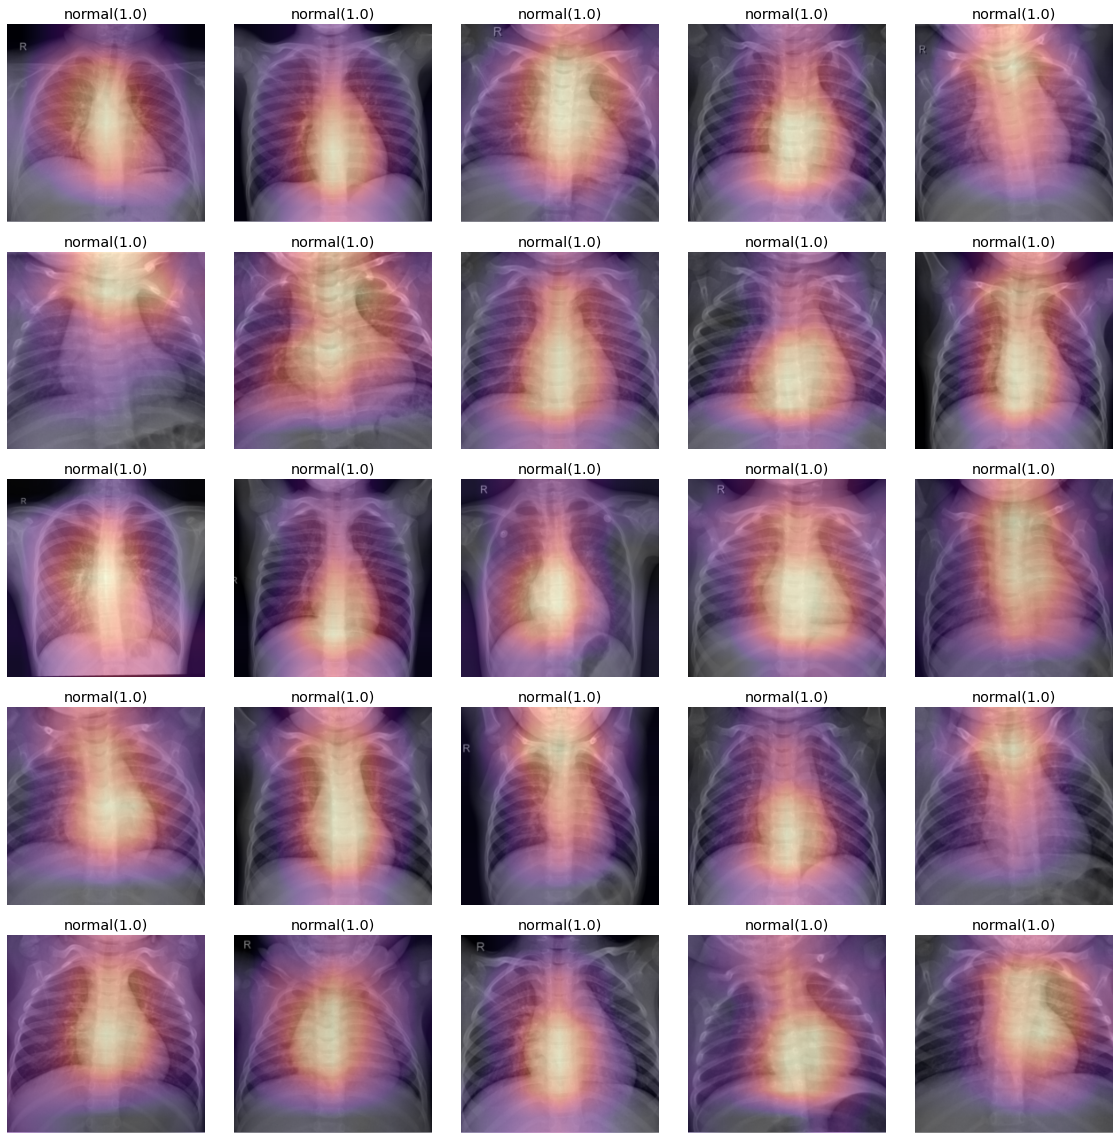

In [17]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        normalprob, pneumoniaprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if normalprob>pneumoniaprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("normal(%s)" % normalprob.round(5))
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("pneumonia(%s)" % pneumoniaprob.round(5))
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

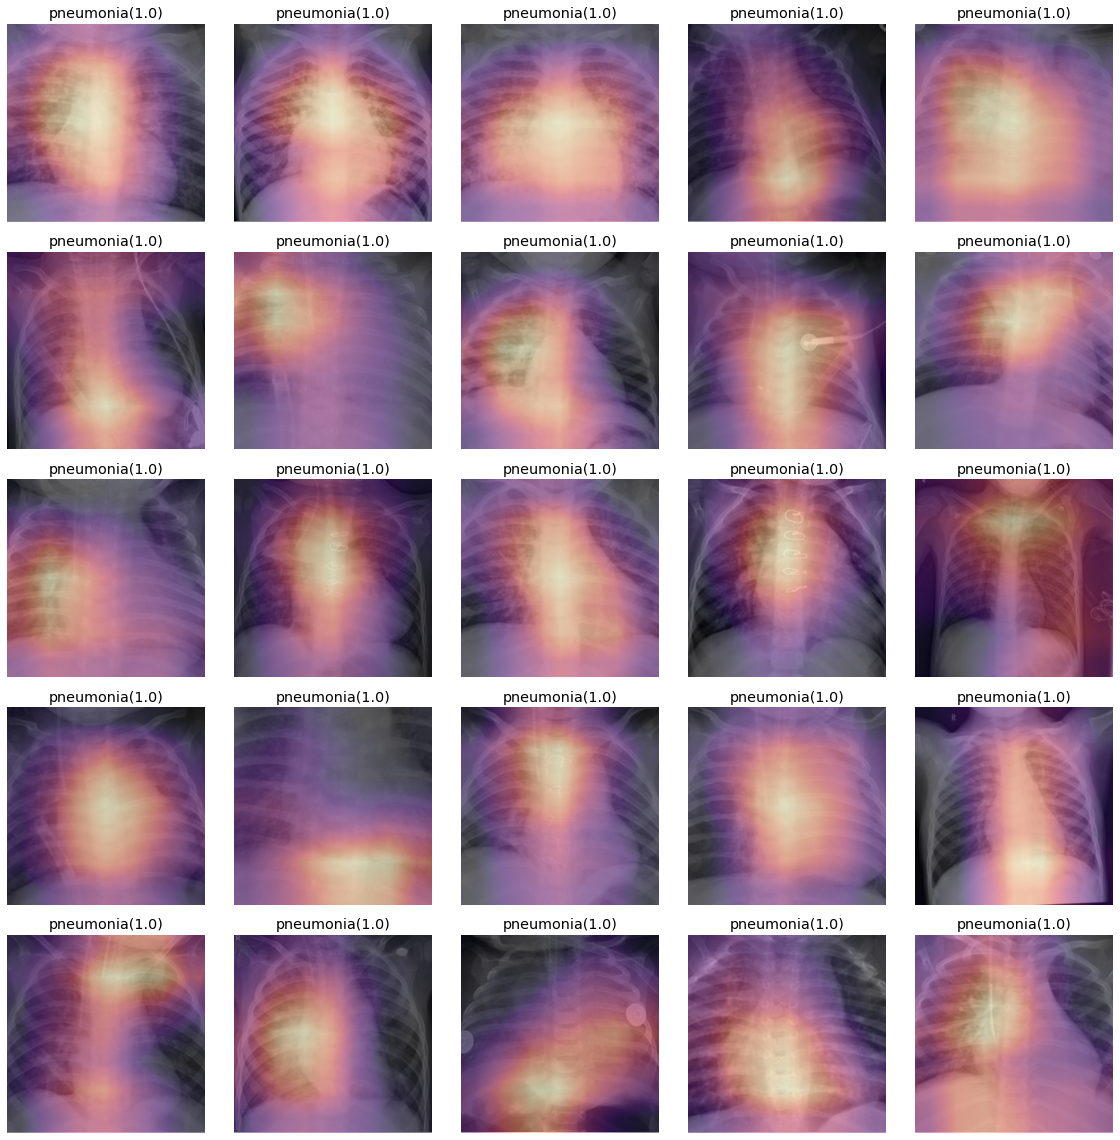

In [18]:
fig, ax = plt.subplots(5,5) 
k=3000 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        normalprob, pneumoniaprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if normalprob>pneumoniaprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("normal(%s)" % normalprob.round(5))
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("pneumonia(%s)" % pneumoniaprob.round(5))
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

---

### SAMPLE

In [132]:
get_image_files(path)[3023]

Path('/home/khy/chest_xray/chest_xray/train/PNEUMONIA/person301_bacteria_1429.jpeg')

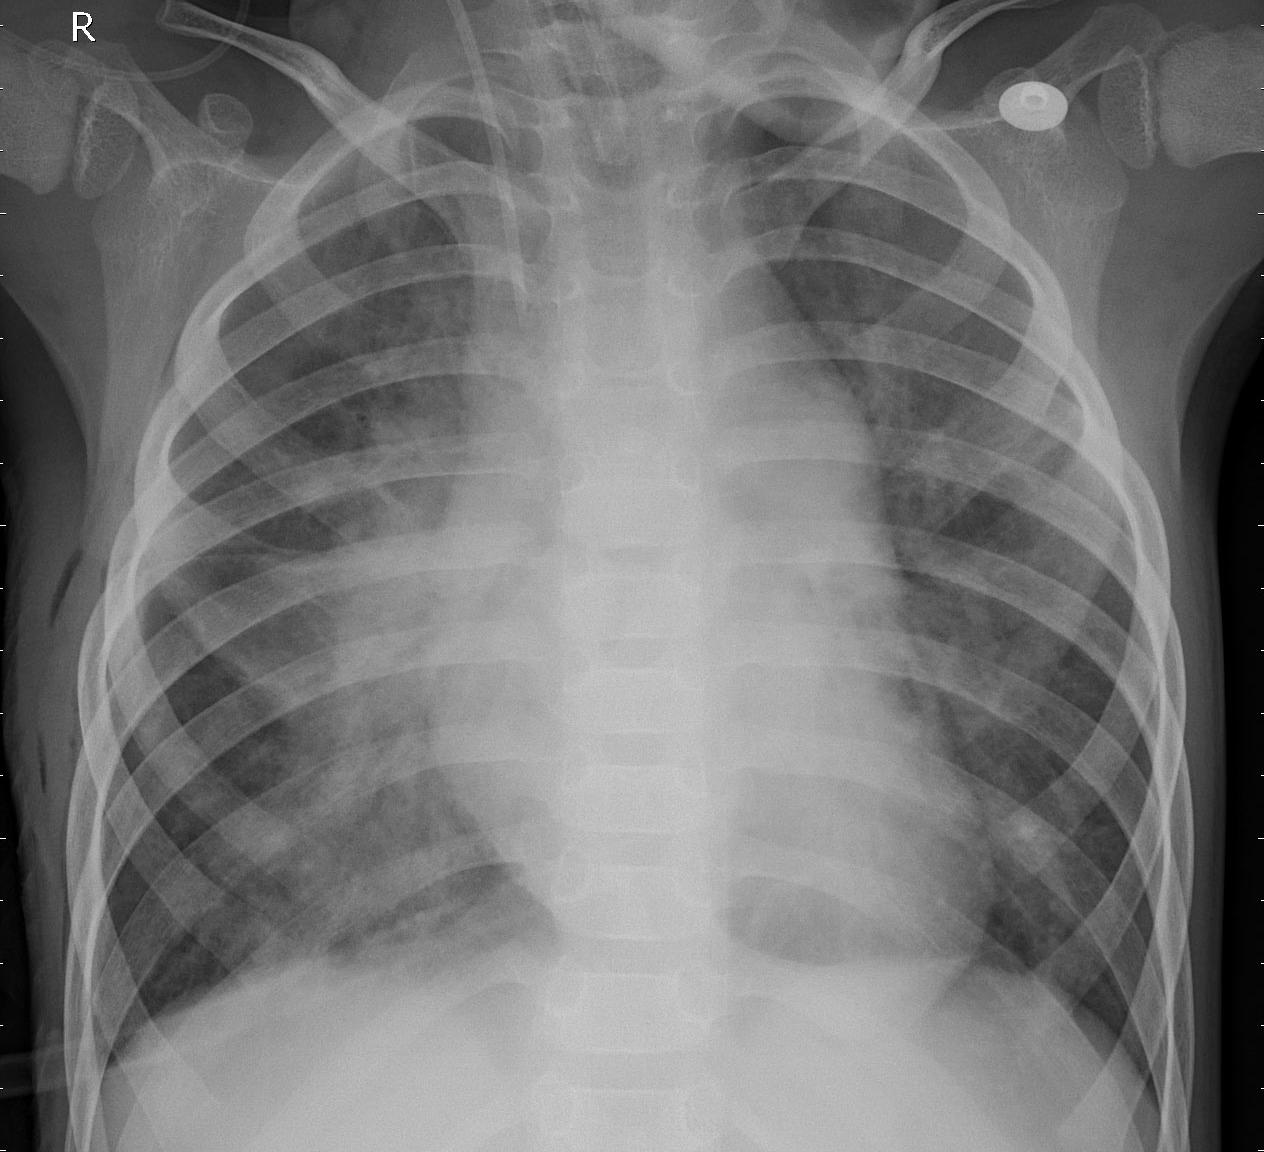

In [135]:
img = PILImage.create(get_image_files(path)[3021])
img

In [136]:
x, = first(dls.test_dl([img]))  #이미지 텐서화

In [137]:
x.shape

torch.Size([1, 3, 224, 224])

#### ★ **판단 근거가 강할수록 파란색 $\to$ 보라색 변함**

In [138]:
a=net(x.to('cpu')).tolist()[0][0]
b=net(x.to('cpu')).tolist()[0][1]
np.exp(a)/(np.exp(a)+np.exp(b)), np.exp(b)/(np.exp(a)+np.exp(b))

(1.0052419841905753e-22, 1.0)

In [139]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x.to('cpu')).squeeze())

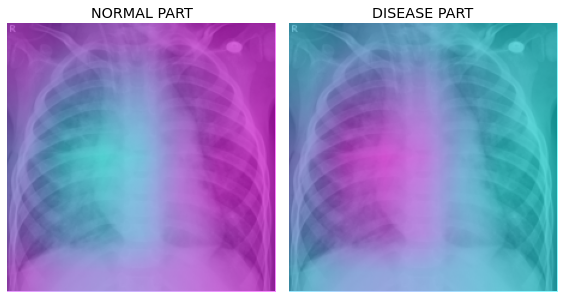

In [140]:
fig, (ax1,ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [141]:
test=camimg[1]-torch.min(camimg[1])

In [168]:
A1=torch.exp(-0.03*test)

In [169]:
A2=1-A1

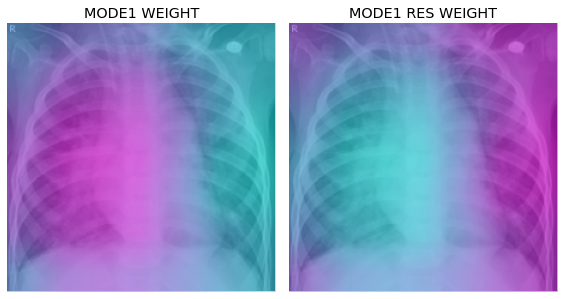

In [170]:
fig, (ax1, ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A2.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE1 WEIGHT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A1.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE1 RES WEIGHT")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

- $\theta$ 가 작아질수록 범위가 좁아지는? 경향

In [171]:
#mode1_res*x
X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
Y1=torch.Tensor(cv2.resize(X1,(224,224),interpolation=cv2.INTER_LINEAR))
x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)

In [172]:
#mode1*x
X12=np.array(A2.to("cpu").detach(),dtype=np.float32)
Y12=torch.Tensor(cv2.resize(X12,(224,224),interpolation=cv2.INTER_LINEAR))
x12=x.squeeze().to('cpu')*Y12#-torch.min(x.squeeze().to('cpu')*Y12)

- 1st CAM 결과를 분리하면 아래와 같음.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


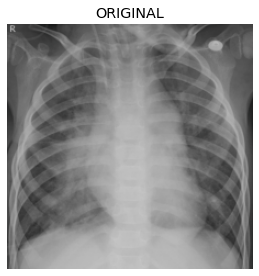

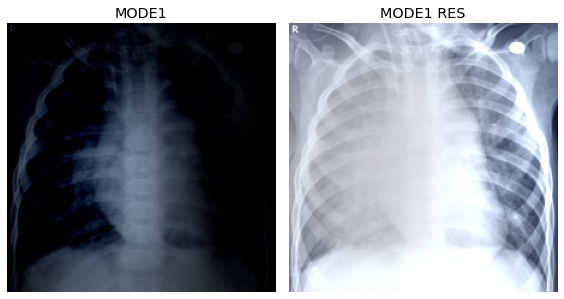

In [175]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x12*0.5).squeeze().show(ax=ax1)  #MODE1
(x1*0.5).squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [176]:
x1=x1.reshape(1,3,224,224)

In [177]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [178]:
camimg1 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x1).squeeze())

- CAM

    - mode1_res에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


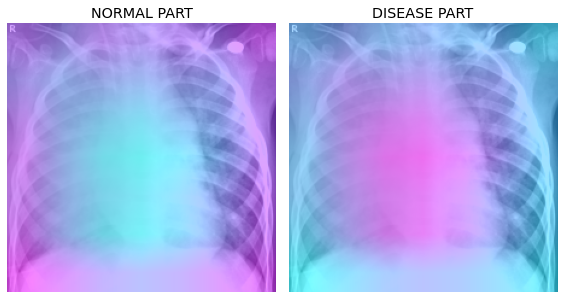

In [182]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
(x1*0.5).squeeze().show(ax=ax1)
ax1.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
(x1*0.5).squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

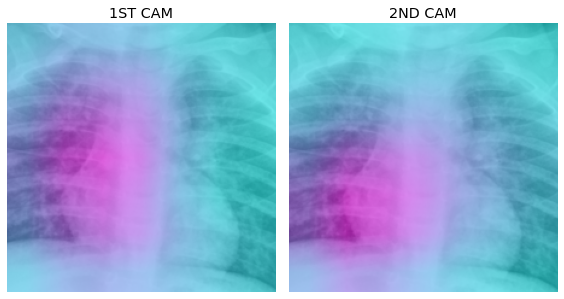

In [218]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [184]:
x1.shape

torch.Size([1, 3, 224, 224])

In [185]:
a1=net(x1).tolist()[0][0]
b1=net(x1).tolist()[0][1]
np.exp(a1)/(np.exp(a1)+np.exp(b1)), np.exp(b1)/(np.exp(a1)+np.exp(b1))

(2.1400014909658421e-16, 0.9999999999999998)

In [186]:
ver2 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x1).squeeze())

- CAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


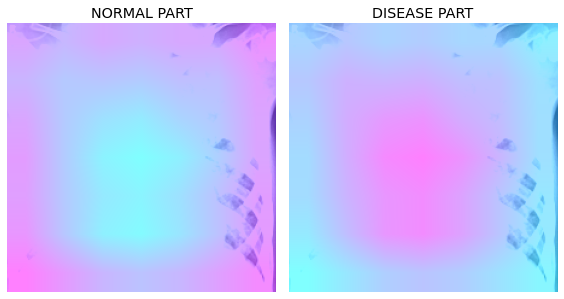

In [189]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x1.squeeze().show(ax=ax1)
ax1.imshow(ver2[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
x1.squeeze().show(ax=ax2)
ax2.imshow(ver2[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

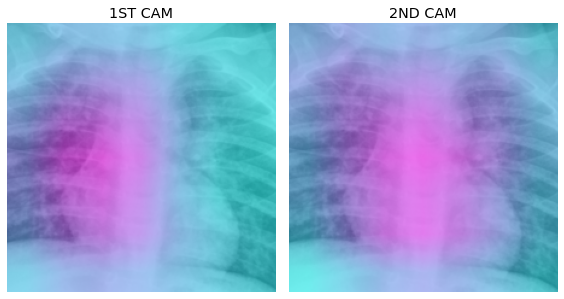

In [219]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(ver2[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [190]:
a1=net(x1).tolist()[0][0]
b1=net(x1).tolist()[0][1]
np.exp(a1)/(np.exp(a1)+np.exp(b1)), np.exp(b1)/(np.exp(a1)+np.exp(b1))

(2.1400014909658421e-16, 0.9999999999999998)

In [221]:
test1=ver2[1]-torch.min(ver2[1])

In [222]:
A3=torch.exp(-0.04*test1)  

In [223]:
A4=1-A3

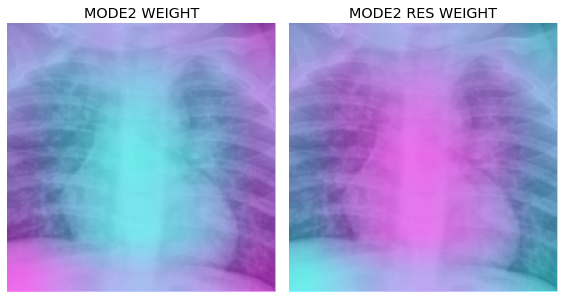

In [224]:
fig, (ax1, ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A3.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE2 WEIGHT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A4.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE2 RES WEIGHT")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [225]:
#mode2_res
X3=np.array(A3.to("cpu").detach(),dtype=np.float32)
Y3=torch.Tensor(cv2.resize(X3,(224,224),interpolation=cv2.INTER_LINEAR))
x3=x.squeeze().to('cpu')*Y1*Y3

In [226]:
#mode2*x
X4=np.array(A4.to("cpu").detach(),dtype=np.float32)
Y4=torch.Tensor(cv2.resize(X4,(224,224),interpolation=cv2.INTER_LINEAR))
x4=x.squeeze().to('cpu')*Y1*Y4

- 2nd CAM 결과를 분리하면 아래와 같음.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


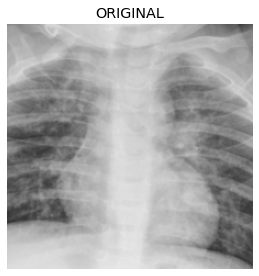

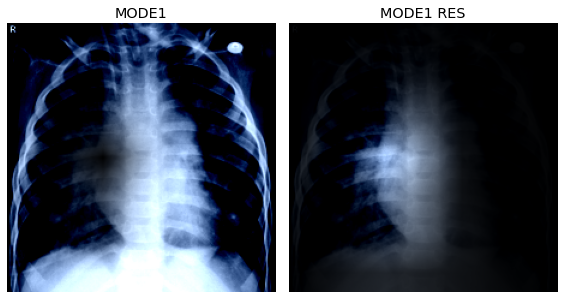

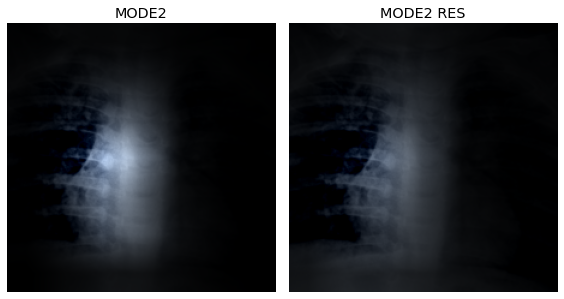

In [227]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x12.squeeze().show(ax=ax1)  
x1.squeeze().show(ax=ax2)  
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x4.squeeze().show(ax=ax1)  
x3.squeeze().show(ax=ax2)  
ax1.set_title("MODE2")
ax2.set_title("MODE2 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [198]:
x3=x3.reshape(1,3,224,224)

In [199]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [200]:
ver3 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x3).squeeze())

- CAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


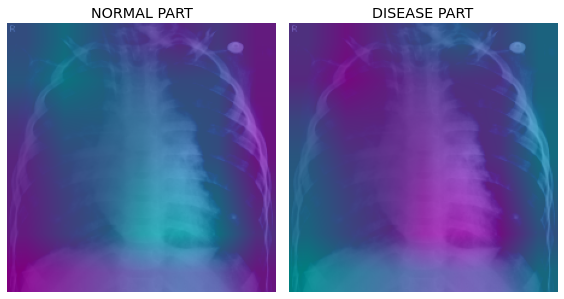

In [201]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x3.squeeze().show(ax=ax1)
ax1.imshow(ver3[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
x3.squeeze().show(ax=ax2)
ax2.imshow(ver3[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [203]:
a2=net(x3).tolist()[0][0]
b2=net(x3).tolist()[0][1]
np.exp(a2)/(np.exp(a2)+np.exp(b2)), np.exp(b2)/(np.exp(a2)+np.exp(b2))

(5.538589438030889e-20, 1.0)

---

### $\theta=0.055$ 

✏️ CAM에서 발견한 특징의 가중치를 낮추는 mode weigth와 CAM에서 발견한 특징을 제외한 부분의 가중치를 살리는 mode res weight를 생성해 mode$n$($n$=number of acting CAM)과 mode$n$ res를 생성한다.  
이 때 k라는 hyper parameter값을 곱해줘서 그 정도를 조정하는데,
- k의 값이 클수록, CAM img의 가중치에 큰 값이 곱해져 이미지가 어떤 클래스로 분류되는데 기여한 부분의 범위가 넓어지며(=mode weight에서 분홍색으로 표시되는 부위가 실제 CAM img보다 넓어짐), residual에서는 더욱 어둡게 나타난다.
- k의 값이 작을수록, CAM img의 가중치에 큰 값이 곱해져 이미지가 어떤 클래스로 분류되는데 기여한 부분의 범위가 CAM img에서 나타난 것과 유사하나, residual에서 완벽하게 지워지지가 않아서 다음 차수에서 동일한 부분이 탐색될 가능성이 높다.  

위와 같은 이유로 적당한 k를 시뮬레이션을 통해 임의로 설정하였다.

- k=0.04로 진행해본 결과, 이전 언급한 것과 같이 1차에서 발견된 특징이 잘 지워지지 않았다. 따라서 2번째 CAM에서 발견된 특징이 1번째 CAM에서 발견된 특징과 유사하다.
- k=0.055로 진행해본 결과, 1차에서 발견된 특징이 residual img에서 잘 지워졌으나(검정색에 가깝게 나타났으나, 픽셀의 값이 0에 가깝게 나타났으나) 폐 내부?의 시각적인 특징들도 함께 사라져 2번째 CAM에서 엉뚱한 결과를 초래했다.



In [204]:
test=camimg[0]-torch.min(camimg[0])

In [205]:
A1=torch.exp(-0.055*test)

In [206]:
A2=1-A1

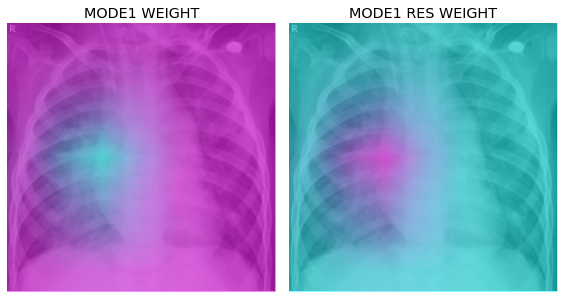

In [207]:
fig, (ax1, ax2) = plt.subplots(1,2) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A2.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE1 WEIGHT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A1.data.to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE1 RES WEIGHT")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [208]:
#mode1_res*x
X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
Y1=torch.Tensor(cv2.resize(X1,(224,224),interpolation=cv2.INTER_LINEAR))
x1=x.squeeze().to('cpu')*Y1

In [209]:
#mode1*x
X12=np.array(A2.to("cpu").detach(),dtype=np.float32)
Y12=torch.Tensor(cv2.resize(X12,(224,224),interpolation=cv2.INTER_LINEAR))
x12=x.squeeze().to('cpu')*Y12

- 1st CAM 결과를 분리하면 아래와 같음.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


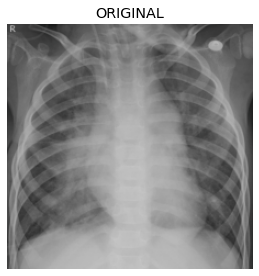

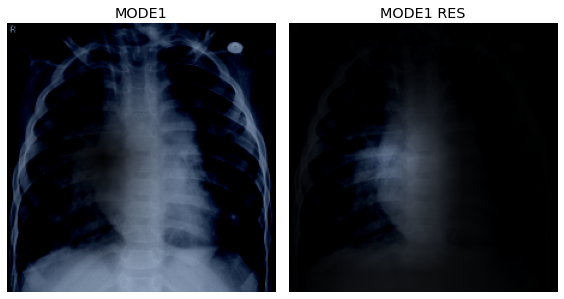

In [210]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x12*0.5).squeeze().show(ax=ax1)  #MODE1
(x1*0.5).squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [211]:
x1=x1.reshape(1,3,224,224)

In [212]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [213]:
camimg1 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x1).squeeze())

- CAM

    - mode1_res에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


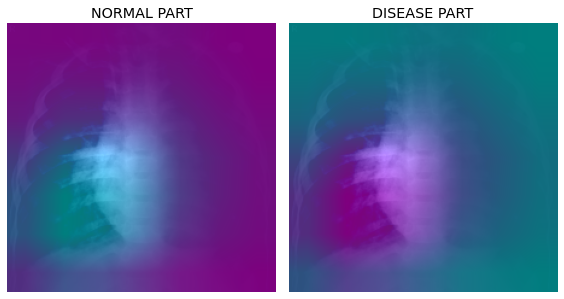

In [214]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x1.squeeze().show(ax=ax1)
ax1.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("NORMAL PART")
#
x1.squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DISEASE PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

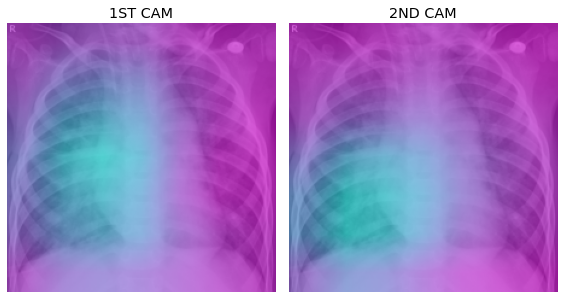

In [215]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [216]:
a1=net(x1).tolist()[0][0]
b1=net(x1).tolist()[0][1]
np.exp(a1)/(np.exp(a1)+np.exp(b1)), np.exp(b1)/(np.exp(a1)+np.exp(b1))

(5.681020375519873e-23, 1.0)

---

- 전체 그림에 적용하기 (n=11712)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

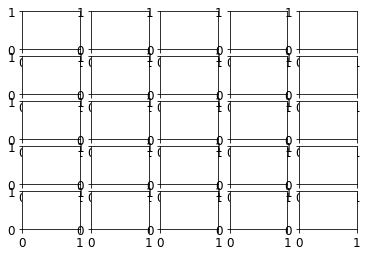

In [ ]:
fig, ax = plt.subplots(5,5) 
k=3000 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        normalprob, pneumoniaprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if normalprob>pneumoniaprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("normal(%s)" % normalprob.round(5))
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,224,224,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("pneumonia(%s)" % pneumoniaprob.round(5))
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [ ]:
import pandas as pd

In [ ]:
col=pd.DataFrame()

In [ ]:
k=0
col=[]
for k in range(5) :
    col[k]=print(k)
    k=k+1

---

refer : https://www.analyticsvidhya.com/blog/2020/10/develop-and-deploy-an-image-classifier-app-using-fastai/

In [ ]:
interp = ClassificationInterpretation.from_learner(lrnr2)
interp.plot_confusion_matrix()

In [ ]:
#cleaner = ImageClassifierCleaner(lrnr2)
#cleaner   #잘못 예측한 이미지 제거_제거될 이미지를 보여주는 것 같음